In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/experiment_ATAC_predictions/traindata_splits_diff_percentages/gaussian_smooth_trimmed_CONTROLS_split_0.2.rds', 'data/20_80_splits_group_by_ind/20_all_samples_normalized_gaussian_smooth_trimmed_CONTROLS.rds', 'data/ATACseq_250kb_bins.txt', "input_train" = 'data/experiment_ATAC_predictions/traindata_splits_diff_percentages/gaussian_smooth_trimmed_CONTROLS_split_0.2.rds', "input_test" = 'data/20_80_splits_group_by_ind/20_all_samples_normalized_gaussian_smooth_trimmed_CONTROLS.rds', "input_atac" = 'data/ATACseq_250kb_bins.txt'),
    output = list('data/experiment_ATAC_predictions/ATAC_predictions/ATAC_pred_lasso_experiment_gaussian_smooth_trimmed_CONTROLS_0.2.rds', 'Trained_models/experiment_models/Lasso_models/lasso_gaussian_smooth_trimmed_CONTROLS_0.2.rds', "output_pred" = 'data/experiment_ATAC_predictions/ATAC_predictions/ATAC_pred_lasso_experiment_gaussian_smooth_trimmed_CONTROLS_0.2.rds', "output_model" = 'Trained_models/experiment_models/Lasso_models/lasso_gaussian_smooth_trimmed_CONTROLS_0.2.rds'),
    params = list(),
    wildcards = list('gaussian_smooth_trimmed_CONTROLS', '0.2', "suffix" = 'gaussian_smooth_trimmed_CONTROLS', "percentage" = '0.2'),
    threads = 5,
    log = list('logs/processed_notebooks/experiments/processed_Lasso_gaussian_smooth_trimmed_CONTROLS_0.2.r.ipynb', "notebook" = 'logs/processed_notebooks/experiments/processed_Lasso_gaussian_smooth_trimmed_CONTROLS_0.2.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 200000, "disk_mb" = 4138, "tmpdir" = '/scratch/56506452', "time" = '10:00:00'),
    config = list(),
    rule = 'ATAC_predictions',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/20_80_experiments',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


# Lasso regression

In [2]:
library(tidyverse)
library(glmnet)

install.packages('glmnetUtils')
library(glmnetUtils)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Updating HTML index of packages in '.Library'
Making 'packages.html' ...

### Read in data and ATAC values, add ATAC values to the dataframe

In [3]:
#all_samples_controls <- readRDS("../data/experiment_ATAC_predictions/CONTROLS_split_0.05.rds")
all_samples_controls <- readRDS(snakemake@input[["input_train"]])
head(all_samples_controls)

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX16584P,chr10_400,2.631513e-05,2.333899e-05,2.184582e-05,1.791544e-05,1.734169e-05,2.067595e-05,2.991432e-05,5.229906e-05,...,6.669944e-05,5.622945e-05,5.563332e-05,6.376241e-05,8.672090e-05,1.175402e-04,1.466025e-04,1.734913e-04,1.854443e-04,1.872024e-04
PGDX16584P,chr10_40,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.580411e-06,...,1.521484e-04,1.620690e-04,1.705875e-04,1.666064e-04,1.581031e-04,1.425705e-04,1.202291e-04,9.459083e-05,8.699327e-05,7.055488e-05
PGDX16584P,chr10_4,9.170700e-06,1.456795e-05,2.533328e-05,3.389408e-05,4.098117e-05,5.511466e-05,6.334005e-05,8.529108e-05,...,1.570130e-04,1.324128e-04,1.153864e-04,9.753395e-05,8.296600e-05,7.137246e-05,5.861745e-05,5.174651e-05,3.929132e-05,2.944597e-05
PGDX16584P,chr10_401,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.818226e-06,8.735955e-06,2.351379e-05,3.678601e-05,...,9.384831e-05,9.452000e-05,9.291026e-05,9.442930e-05,9.545805e-05,9.487706e-05,9.215886e-05,8.511235e-05,8.064266e-05,7.841438e-05
PGDX16584P,chr10_402,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.379255e-04,1.385718e-04,1.340640e-04,1.251838e-04,1.232368e-04,1.183956e-04,1.056570e-04,9.766760e-05,8.040467e-05,6.429293e-05
PGDX16584P,chr10_403,2.050361e-05,2.500180e-05,2.671068e-05,2.500180e-05,2.050361e-05,1.984697e-05,1.854796e-05,1.984697e-05,...,2.510651e-04,2.656162e-04,2.628551e-04,2.485226e-04,2.215651e-04,1.886435e-04,1.566933e-04,1.271365e-04,1.163428e-04,1.098581e-04


In [4]:
#ATAC <- read.table("../../../data/ATACseq_250kb_bins.txt", header = FALSE)
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)

colnames(ATAC) <- c("bin", "ATAC_observed")
head(ATAC)

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_ATAC_controls <- inner_join(all_samples_controls, ATAC, by="bin")

head(all_samples_ATAC_controls)

bin,ATAC_observed
chr1_0,0.05376791
chr10_0,0.29698782
chr10_1,0.40893151
chr10_10,0.30582283
chr10_100,0.59316570
chr10_101,0.47641373


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message:
“Column `bin` joining factor and character vector, coercing into character vector”

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X392,X393,X394,X395,X396,X397,X398,X399,X400,ATAC_observed
PGDX16584P,chr10_400,2.631513e-05,2.333899e-05,2.184582e-05,1.791544e-05,1.734169e-05,2.067595e-05,2.991432e-05,5.229906e-05,...,5.622945e-05,5.563332e-05,6.376241e-05,8.672090e-05,1.175402e-04,1.466025e-04,1.734913e-04,1.854443e-04,1.872024e-04,0.5866651
PGDX16584P,chr10_40,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.580411e-06,...,1.620690e-04,1.705875e-04,1.666064e-04,1.581031e-04,1.425705e-04,1.202291e-04,9.459083e-05,8.699327e-05,7.055488e-05,0.1996134
PGDX16584P,chr10_4,9.170700e-06,1.456795e-05,2.533328e-05,3.389408e-05,4.098117e-05,5.511466e-05,6.334005e-05,8.529108e-05,...,1.324128e-04,1.153864e-04,9.753395e-05,8.296600e-05,7.137246e-05,5.861745e-05,5.174651e-05,3.929132e-05,2.944597e-05,0.5968816
PGDX16584P,chr10_401,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.818226e-06,8.735955e-06,2.351379e-05,3.678601e-05,...,9.452000e-05,9.291026e-05,9.442930e-05,9.545805e-05,9.487706e-05,9.215886e-05,8.511235e-05,8.064266e-05,7.841438e-05,0.2905764
PGDX16584P,chr10_402,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.385718e-04,1.340640e-04,1.251838e-04,1.232368e-04,1.183956e-04,1.056570e-04,9.766760e-05,8.040467e-05,6.429293e-05,0.2319729
PGDX16584P,chr10_403,2.050361e-05,2.500180e-05,2.671068e-05,2.500180e-05,2.050361e-05,1.984697e-05,1.854796e-05,1.984697e-05,...,2.656162e-04,2.628551e-04,2.485226e-04,2.215651e-04,1.886435e-04,1.566933e-04,1.271365e-04,1.163428e-04,1.098581e-04,0.2262170


In [5]:
ATAC_val <- all_samples_ATAC_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_ATAC_controls %>% select(sample, bin)
all_samples_ATAC_controls = all_samples_ATAC_controls %>% select(-c(ATAC_observed, sample, bin))

head(all_samples_ATAC_controls)
head(ATAC_val)

X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
2.631513e-05,2.333899e-05,2.184582e-05,1.791544e-05,1.734169e-05,2.067595e-05,2.991432e-05,5.229906e-05,8.141292e-05,1.232286e-04,...,6.669944e-05,5.622945e-05,5.563332e-05,6.376241e-05,8.672090e-05,1.175402e-04,1.466025e-04,1.734913e-04,1.854443e-04,1.872024e-04
0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.580411e-06,1.011788e-05,2.165297e-05,...,1.521484e-04,1.620690e-04,1.705875e-04,1.666064e-04,1.581031e-04,1.425705e-04,1.202291e-04,9.459083e-05,8.699327e-05,7.055488e-05
9.170700e-06,1.456795e-05,2.533328e-05,3.389408e-05,4.098117e-05,5.511466e-05,6.334005e-05,8.529108e-05,1.019567e-04,1.285999e-04,...,1.570130e-04,1.324128e-04,1.153864e-04,9.753395e-05,8.296600e-05,7.137246e-05,5.861745e-05,5.174651e-05,3.929132e-05,2.944597e-05
0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.818226e-06,8.735955e-06,2.351379e-05,3.678601e-05,5.612424e-05,8.216170e-05,...,9.384831e-05,9.452000e-05,9.291026e-05,9.442930e-05,9.545805e-05,9.487706e-05,9.215886e-05,8.511235e-05,8.064266e-05,7.841438e-05
0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.379255e-04,1.385718e-04,1.340640e-04,1.251838e-04,1.232368e-04,1.183956e-04,1.056570e-04,9.766760e-05,8.040467e-05,6.429293e-05
2.050361e-05,2.500180e-05,2.671068e-05,2.500180e-05,2.050361e-05,1.984697e-05,1.854796e-05,1.984697e-05,2.561857e-05,4.450571e-05,...,2.510651e-04,2.656162e-04,2.628551e-04,2.485226e-04,2.215651e-04,1.886435e-04,1.566933e-04,1.271365e-04,1.163428e-04,1.098581e-04


ATAC_observed
0.5866651
0.1996134
0.5968816
0.2905764
0.2319729
0.2262170


# Lasso regression

## Cross validation to find the best lambda and alpha

In [6]:
get_cvm <- function(model) {
   index <- match(model$lambda.min, model$lambda)
  model$cvm[index]
}

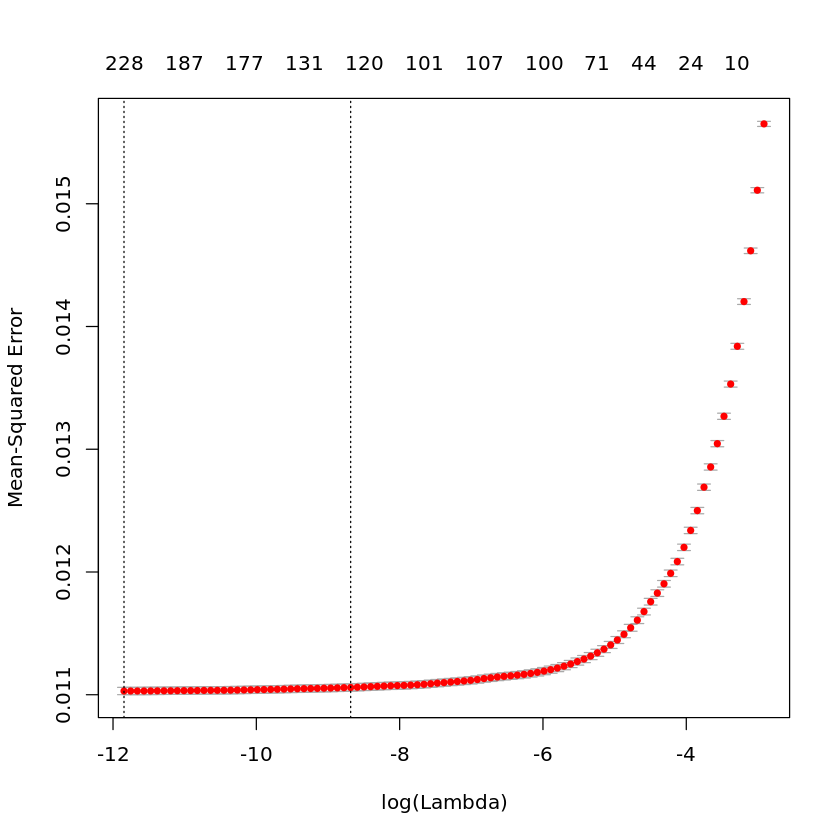

In [7]:
set.seed(0)

y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_controls %>% as.matrix()

######### finding the best alpha #########
set.seed(0)
lasso_cva <- glmnetUtils::cva.glmnet(X, y, nfolds = 10)
enet_performance <- data.frame(alpha = lasso_cva$alpha)
models <- lasso_cva$modlist
enet_performance$cvm <- vapply(models, get_cvm, numeric(1))

minix <- which.min(enet_performance$cvm)
best_alpha <- lasso_cva$alpha[minix]
###########################################

######### finding the best lambda #########
set.seed(0)
lasso_cv <- glmnet::cv.glmnet(X, y, alpha = best_alpha,
                      standardize = TRUE, nfolds = 10)

plot(lasso_cv)
###########################################

In [8]:
(lambda_cv <- lasso_cv$lambda.min)

[1] 7.161722e-06

## Fit the model on all traindata controls

In [9]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_controls %>% as.matrix()

fit       <- glmnet::glmnet(X, y, alpha = best_alpha, lambda = lambda_cv, standardize = TRUE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])


## Predict on normalized 20% of controls using the model (fitted on train controls) and save the predictions to file

In [10]:
#filename = "../../../data/all_samples_normalized_CASES.csv"
#test_data = readRDS("../../data/20_80_splits/20_all_samples_normalized_CONTROLS.rds")

test_data = readRDS(snakemake@input[["input_test"]])

In [11]:
head(test_data)

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX16571P,chr10_400,3.012834e-05,3.218762e-05,3.012834e-05,2.470780e-05,1.775275e-05,1.733935e-05,1.733935e-05,1.775275e-05,...,9.494004e-05,8.581908e-05,6.847973e-05,5.483614e-05,4.246055e-05,2.892833e-05,1.733935e-05,6.163774e-06,0.000000e+00,0.000000e+00
PGDX16571P,chr10_40,2.259093e-05,3.144145e-05,3.833924e-05,4.095974e-05,3.833924e-05,3.144145e-05,2.259093e-05,2.206486e-05,...,8.494775e-05,6.777278e-05,5.988398e-05,5.402643e-05,4.095974e-05,3.833924e-05,3.144145e-05,2.259093e-05,1.422127e-05,7.843594e-06
PGDX16571P,chr10_4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.878457e-06,...,6.031131e-05,7.596375e-05,9.393299e-05,1.104149e-04,1.193371e-04,1.233476e-04,1.215056e-04,1.095854e-04,9.623104e-05,7.366570e-05
PGDX16571P,chr10_401,5.645446e-05,6.883975e-05,7.354497e-05,6.883975e-05,5.645446e-05,4.056297e-05,3.961840e-05,3.961840e-05,...,4.803643e-05,5.464648e-05,6.652956e-05,8.202460e-05,9.322694e-05,1.103014e-04,1.145396e-04,1.094027e-04,9.744913e-05,8.202460e-05
PGDX16571P,chr10_402,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.805601e-05,1.077642e-04,1.346574e-04,1.572478e-04,1.780925e-04,1.831648e-04,1.701923e-04,1.421209e-04,1.103068e-04,8.356500e-05
PGDX16571P,chr10_403,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.157497e-04,2.061356e-04,1.790666e-04,1.599142e-04,1.419695e-04,1.245615e-04,1.059864e-04,8.870360e-05,6.792235e-05,5.704793e-05


In [12]:
test_data_samples_bin_rm <- test_data %>% select(-c("sample", "bin")) %>% as.matrix()
tmp <- as.vector(predict(fit, s=lambda_cv, test_data_samples_bin_rm))

In [13]:
pred_tibble <- tibble(sample = test_data$sample, bin = test_data$bin)
pred_tibble <- inner_join(pred_tibble, ATAC, by="bin")
pred_tibble <- pred_tibble %>% mutate(ATAC_predicted = tmp)

Warning message:
“Column `bin` joining factor and character vector, coercing into character vector”

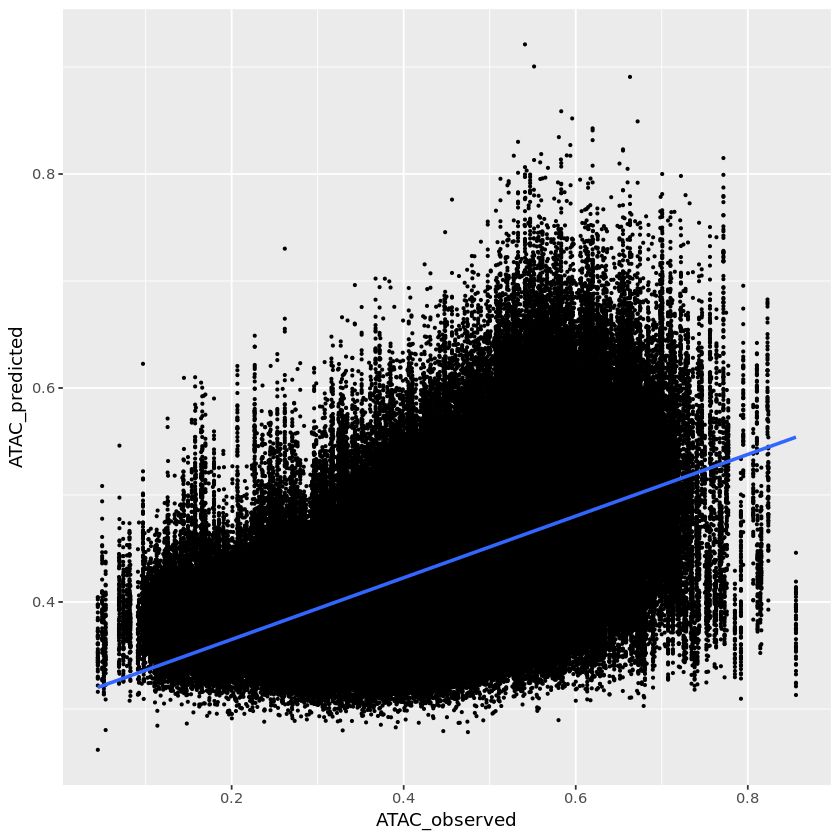

In [14]:
ggplot(pred_tibble, aes(x = ATAC_observed, y = ATAC_predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [15]:
cor(pred_tibble$ATAC_observed, pred_tibble$ATAC_predicted)

[1] 0.5393067

In [16]:
ae    <- abs(pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)
(mae   <- mean(ae))

[1] 0.08190671

In [17]:
se    <- (pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

[1] 0.1053588

In [18]:
saveRDS(pred_tibble, file = snakemake@output[["output_pred"]])